<a href="https://colab.research.google.com/github/Nisasoylu/GNN/blob/main/GNN_Experiment_KarateClub_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install torch-geometric

In [82]:
import torch
from torch.nn import Linear # for linear transformation
from torch_geometric.nn import GCNConv # graph convolutional layer
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
from sklearn.manifold import TSNE

In [83]:
dataset = KarateClub()
data = dataset[0]  # Get the first graph object.
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [84]:
data.stores

[{'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
    

In [85]:
data.is_directed()

False

In [86]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

Only 4 nodes have mask value set as True, it means only 4 out of 34 nodes have community or class assignment, rest of the 30 nodes needs community assignment.

Train Mask -> In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

In [87]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

 **GNN** is a general class of neural network architectures for **graph-structured data**, while **GCN** is a specific type of GNN that applies **convolutional operations** directly on the graph. GCNs are widely used due to their simplicity and effectiveness in capturing graph structure and node features. However, there are many other types of GNN architectures beyond GCNs, each with its own advantages and applications.

In [88]:
class GCN(torch.nn.Module):
  def __init__(self, data):
    super().__init__()
    torch.manual_seed(1234) # It is used to set the random seed in PyTorch, ensuring that random operations produce
                               # the same results each time your code is run.
    self.conv1 = GCNConv(data.num_node_features, 4)  # dataset.num_node_features = 34,
                                                     # convolutional layer will produce 4 output features for each node.
    self.conv2 = GCNConv(4, 4) # It takes 4 input features from the previous layer and
                               # produces 4 output features for each node.
    self.conv3 = GCNConv(4, 2) # It takes 4 input features from the previous layer and
                               # produces 4 output features for each node.
    self.classifier = Linear(2, dataset.num_classes) # It takes 2 input features (presumably the output features
                                                     # from the last graph convolutional layer) and
                                                     # produces dataset.num_classes output features, representing
                                                     # the class scores for each class in the dataset.
                                                     # dataset.num_classes = 4


  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()

    out = self.classifier(h)
    return out, h

model = GCN(data)
print(model)

print("Number of nodes:", dataset.num_node_features)
print("Number of classes:", dataset.num_classes)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Number of nodes: 34
Number of classes: 4


In [89]:
out, h = model.forward(data.x, data.edge_index)
print(out)
print(h)

tensor([[-0.1800,  0.6862,  0.1598,  0.1413],
        [-0.1946,  0.6587,  0.1327,  0.1069],
        [-0.1860,  0.6638,  0.1398,  0.1144],
        [-0.1890,  0.6638,  0.1388,  0.1139],
        [-0.1999,  0.6750,  0.1442,  0.1249],
        [-0.1905,  0.6825,  0.1533,  0.1351],
        [-0.1895,  0.6814,  0.1528,  0.1341],
        [-0.1931,  0.6610,  0.1351,  0.1099],
        [-0.1940,  0.6523,  0.1278,  0.0997],
        [-0.1952,  0.6484,  0.1243,  0.0950],
        [-0.1975,  0.6764,  0.1460,  0.1269],
        [-0.1836,  0.6835,  0.1564,  0.1375],
        [-0.1935,  0.6638,  0.1372,  0.1130],
        [-0.1913,  0.6574,  0.1328,  0.1060],
        [-0.2014,  0.6454,  0.1198,  0.0904],
        [-0.1991,  0.6445,  0.1198,  0.0898],
        [-0.1890,  0.6801,  0.1518,  0.1326],
        [-0.2028,  0.6605,  0.1315,  0.1076],
        [-0.1974,  0.6422,  0.1186,  0.0874],
        [-0.1994,  0.6531,  0.1267,  0.0997],
        [-0.1955,  0.6516,  0.1268,  0.0986],
        [-0.2052,  0.6534,  0.1250

In [90]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(12,8))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set1")
    if epoch is not None and loss is not None:
        plt.xlabel(f"Epoch: {epoch}, Loss: {loss.item():.4f}", fontsize=16)
    plt.show()

In [91]:
def visualize_tsne(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set1")
    plt.show()

In [92]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

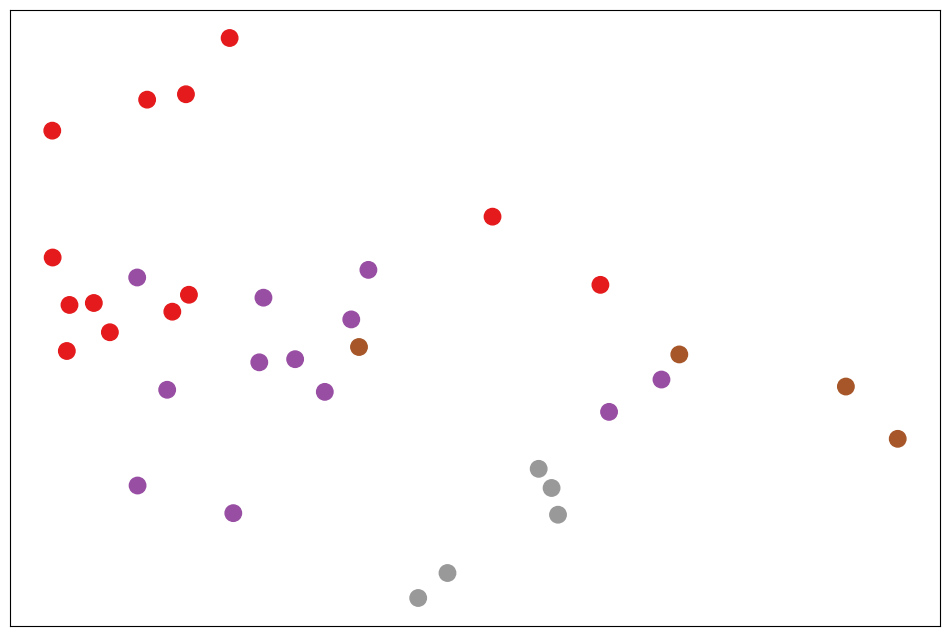

In [93]:
visualize_embedding(h, data.y)

In [94]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

<IPython.core.display.Javascript object>

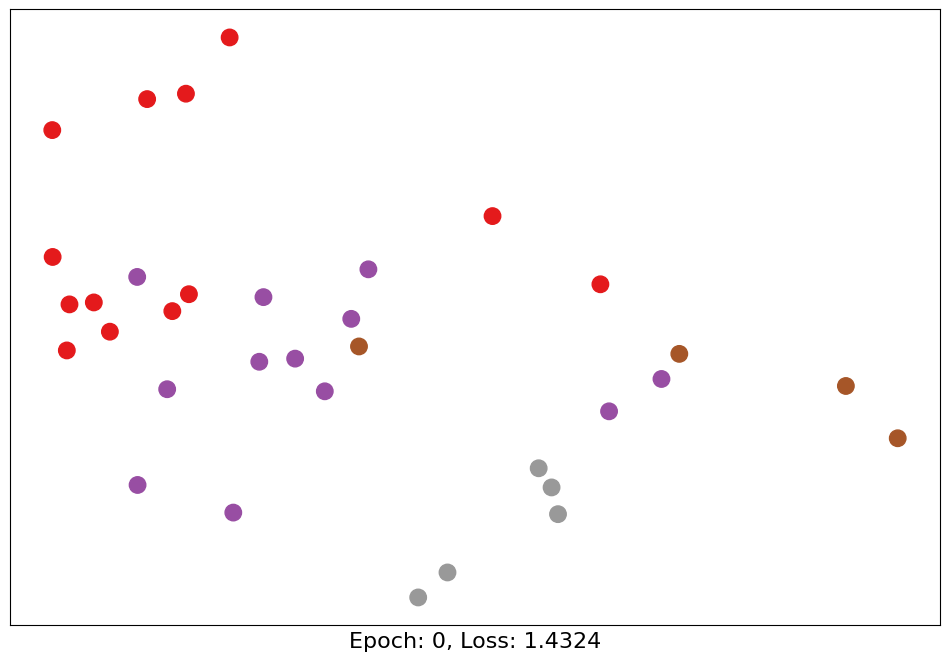

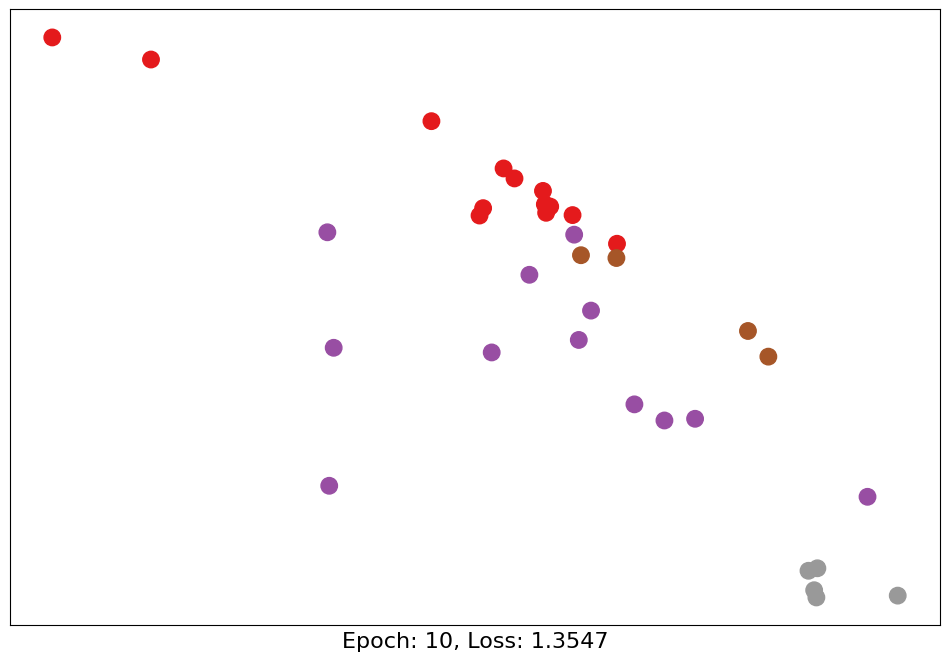

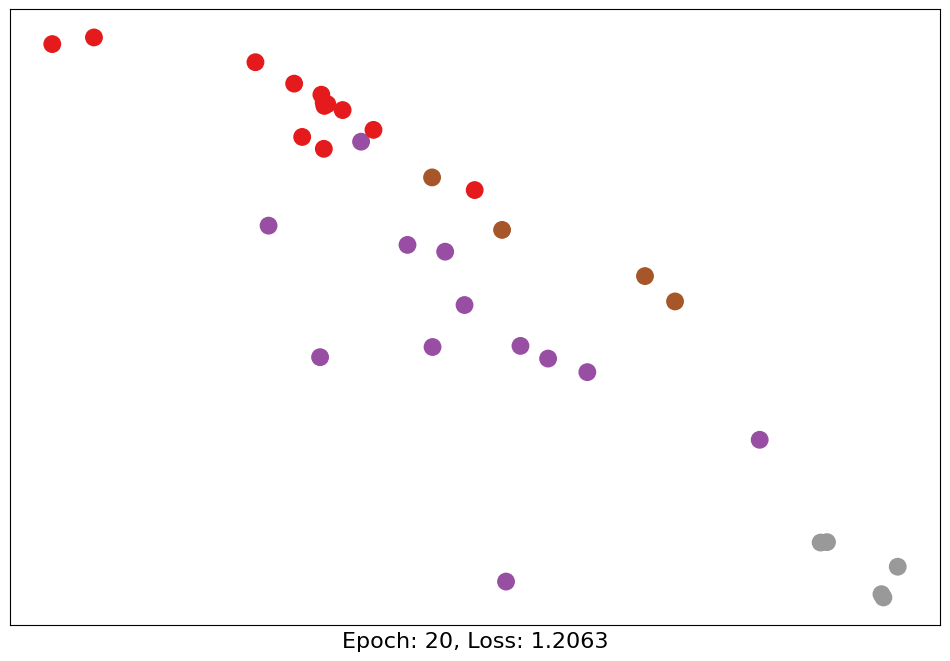

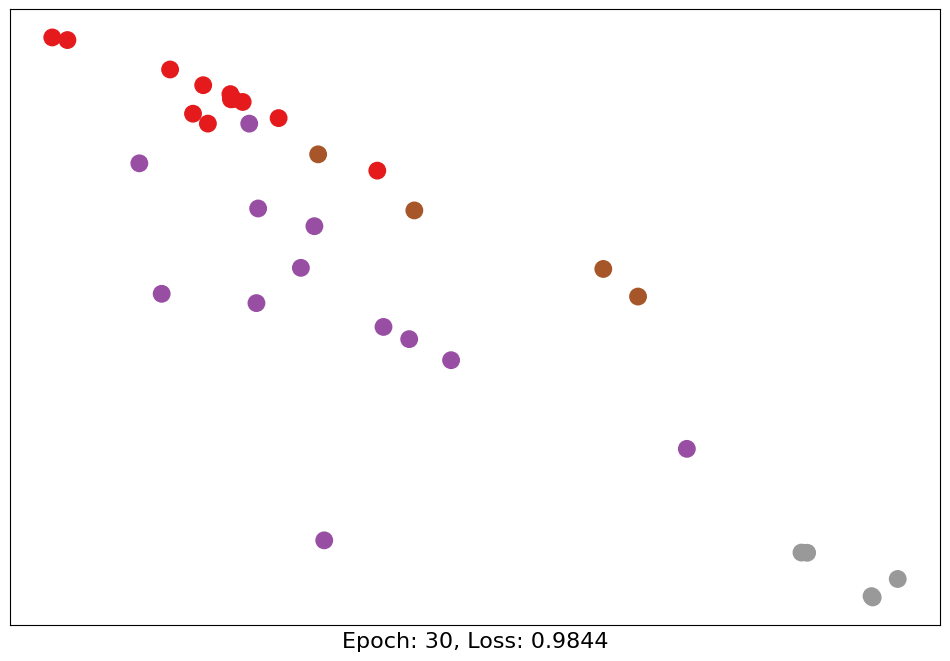

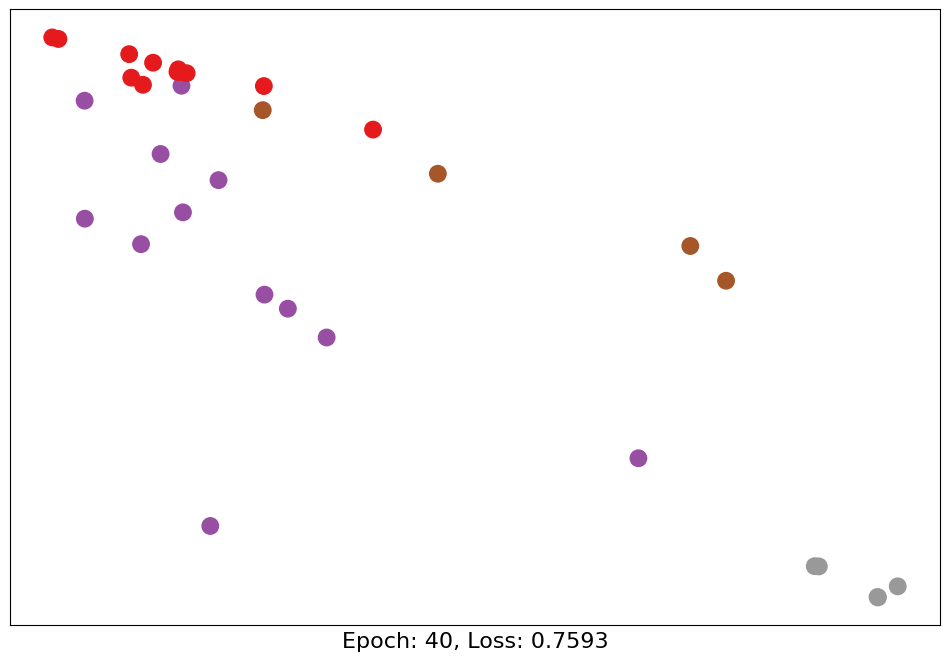

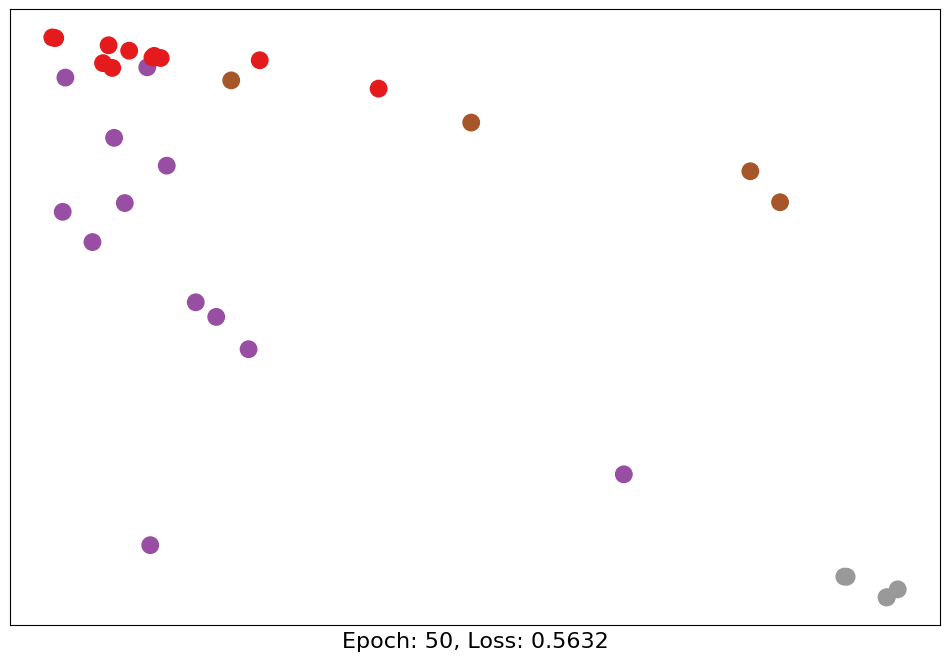

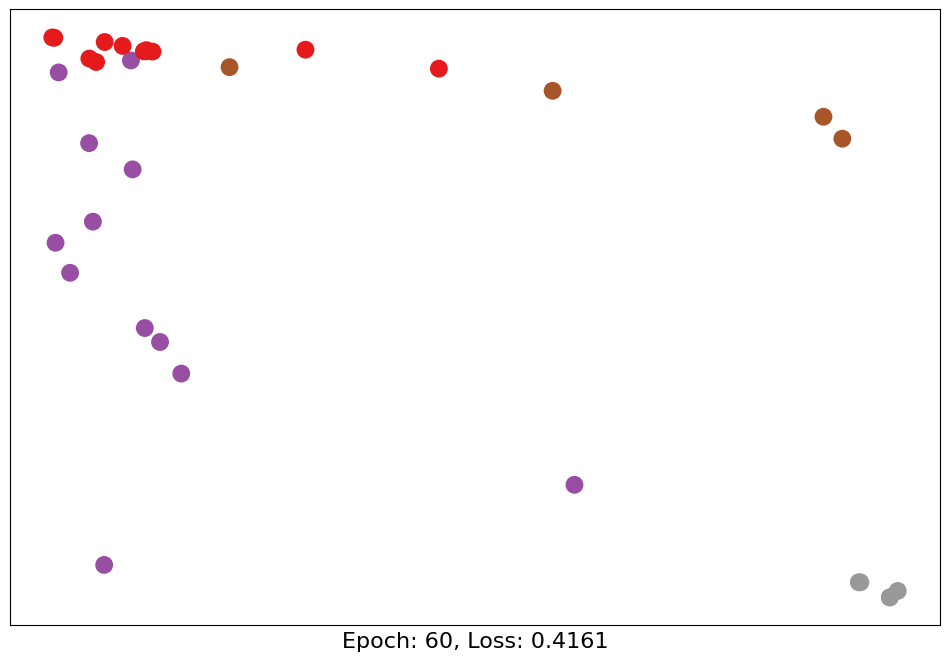

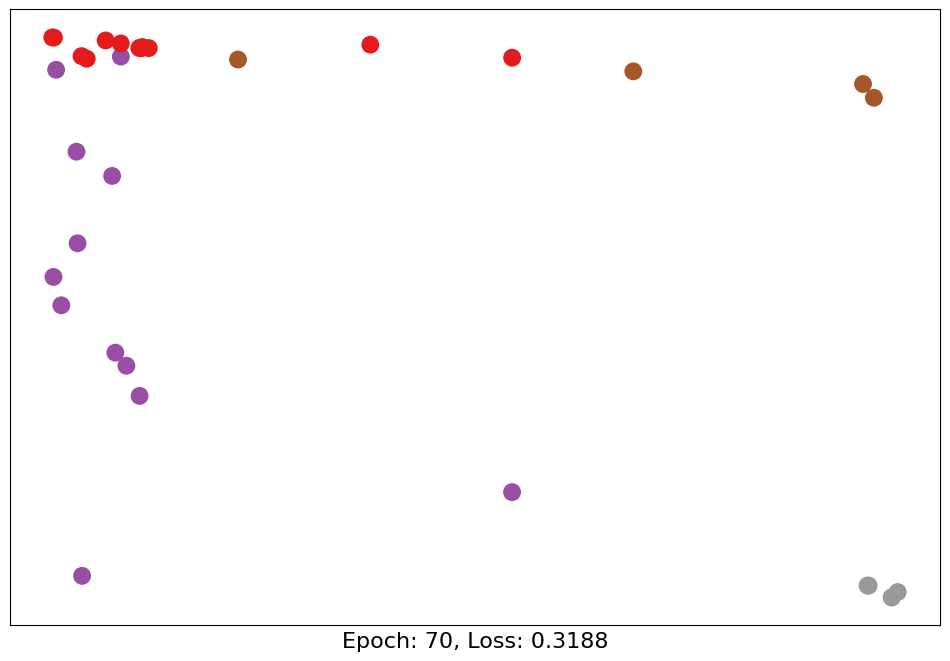

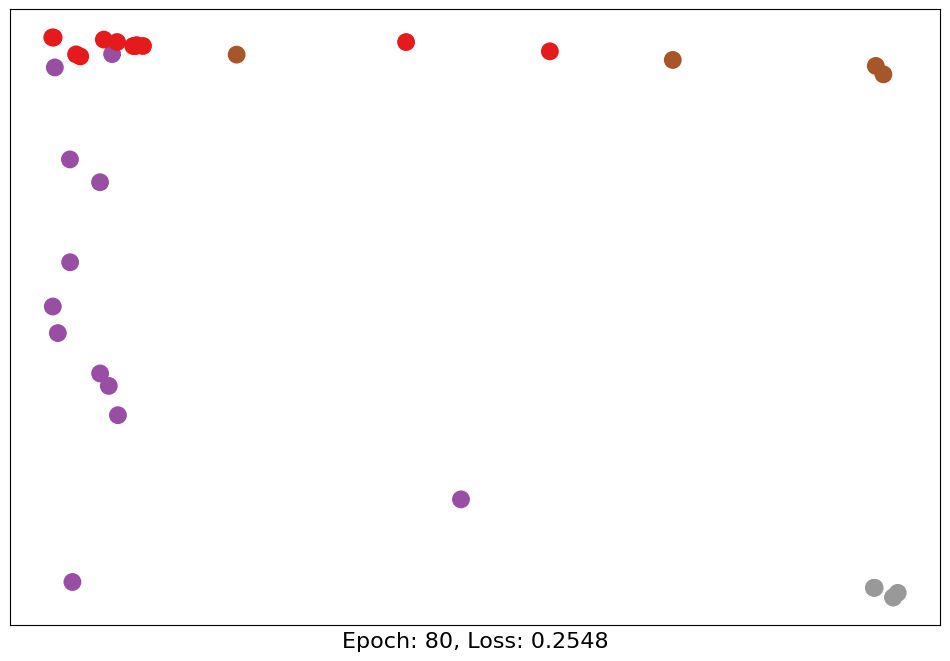

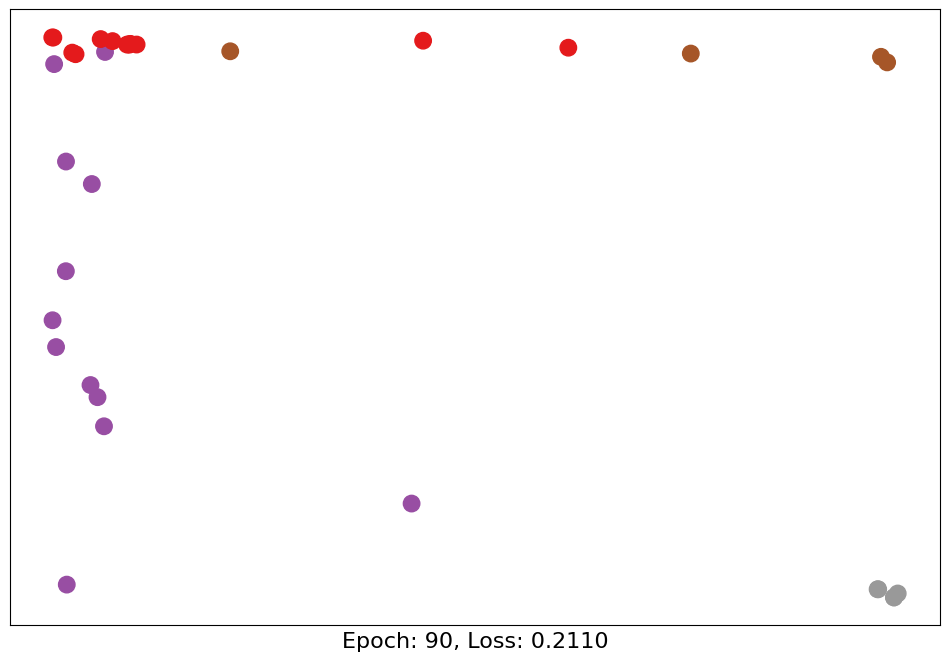

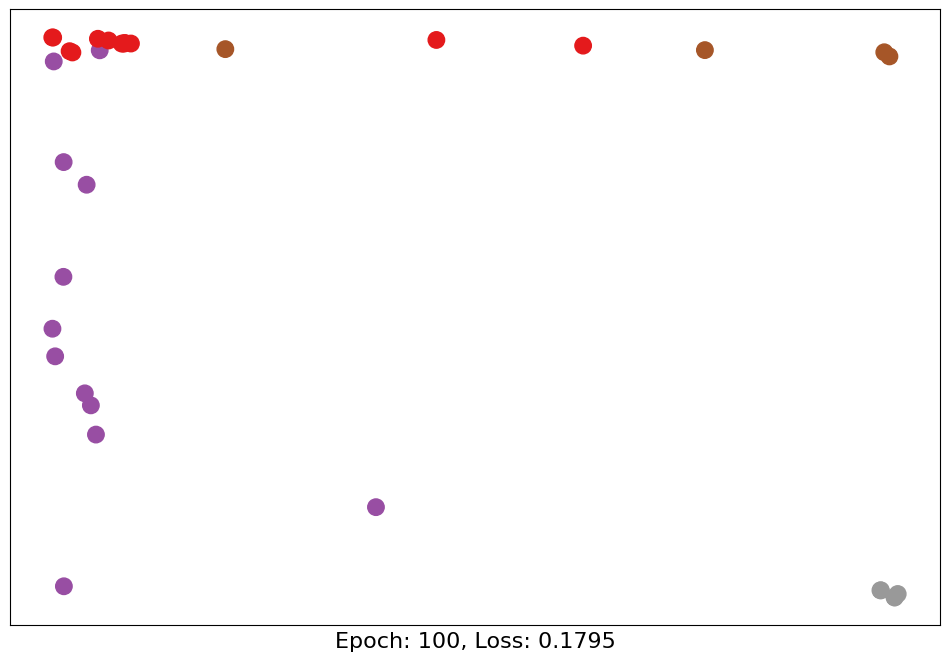

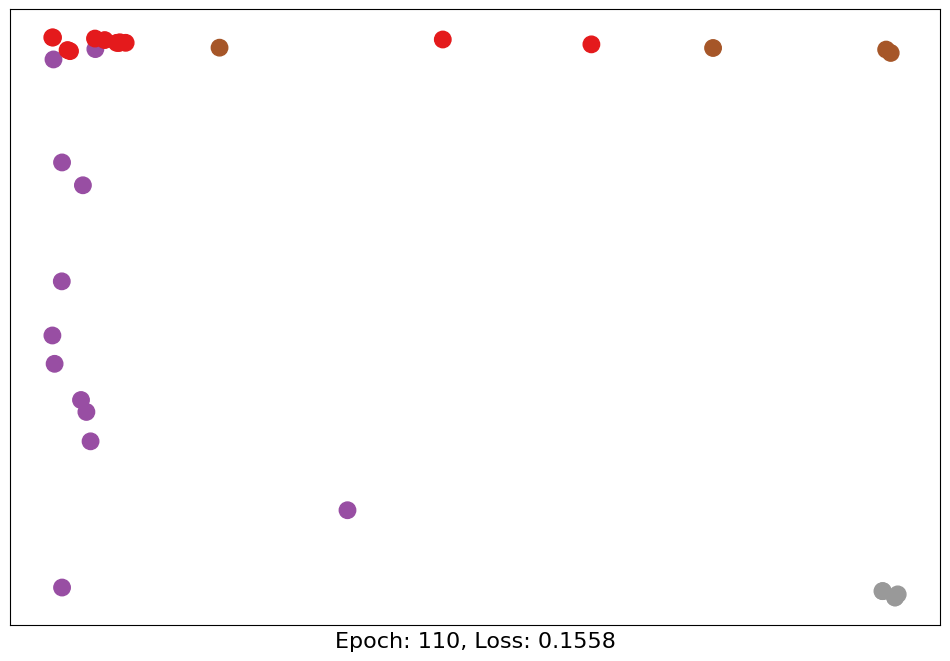

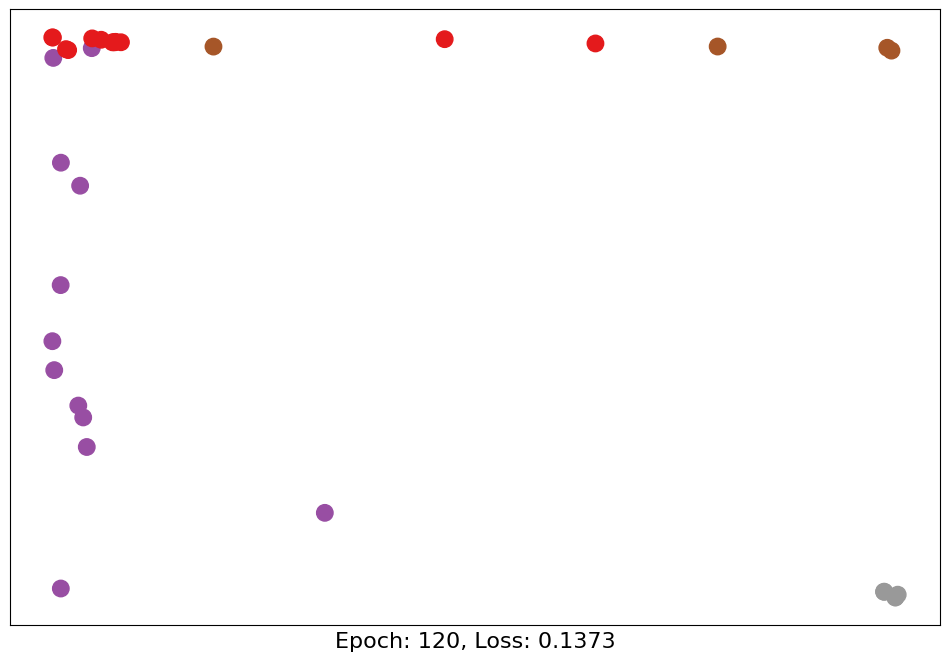

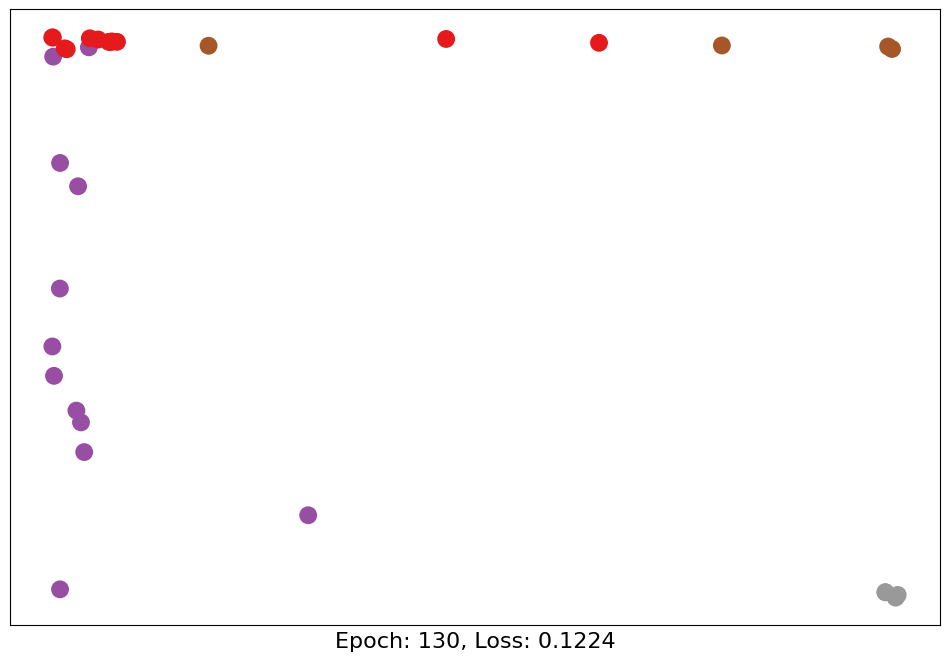

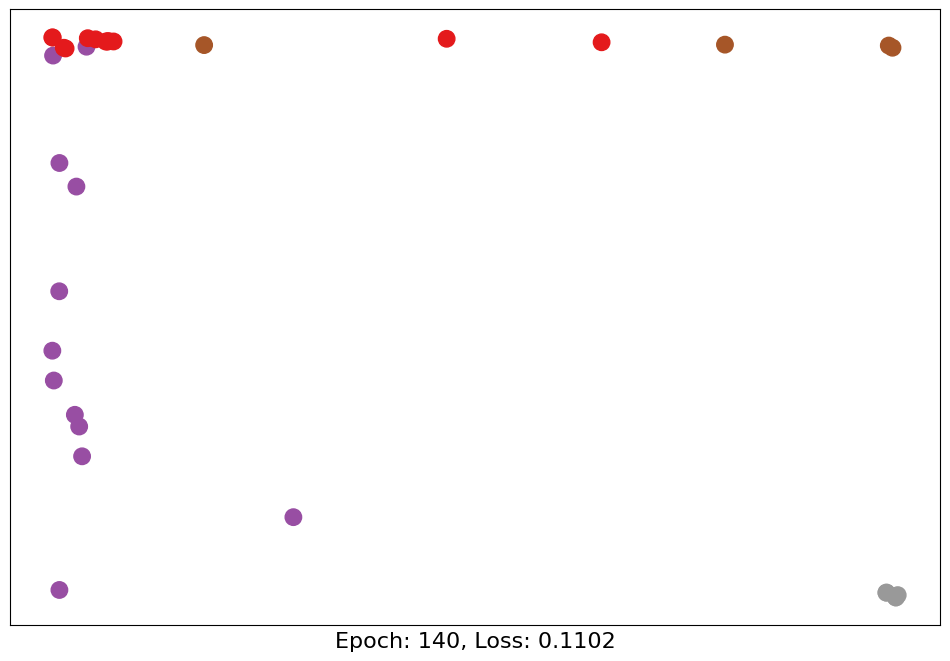

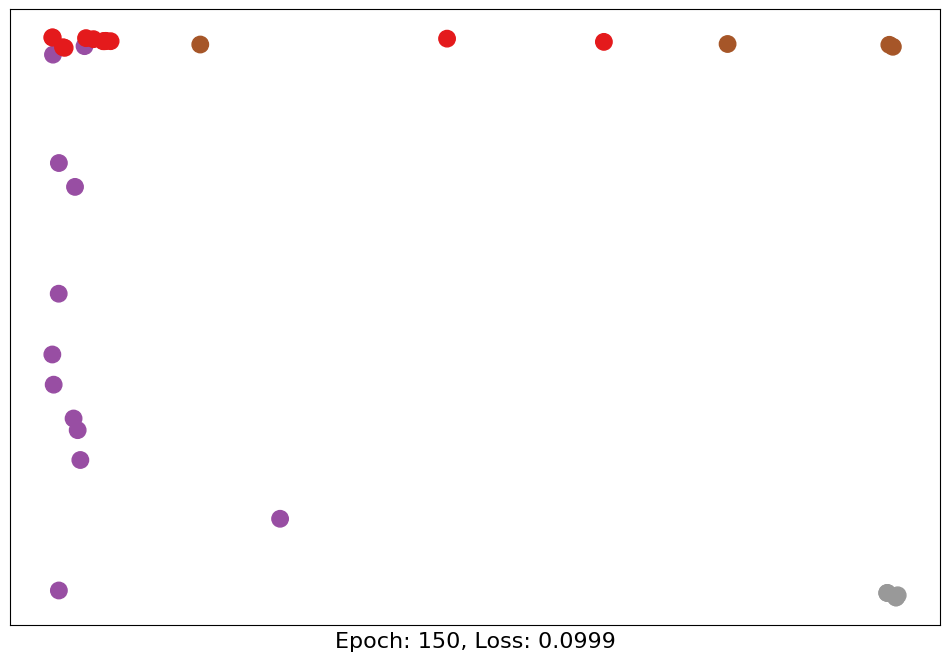

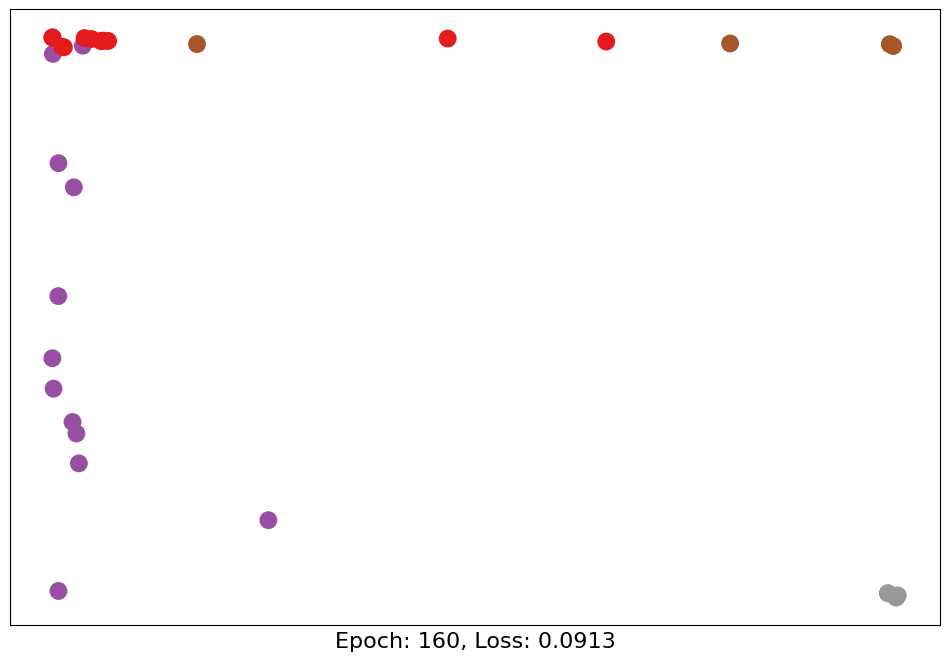

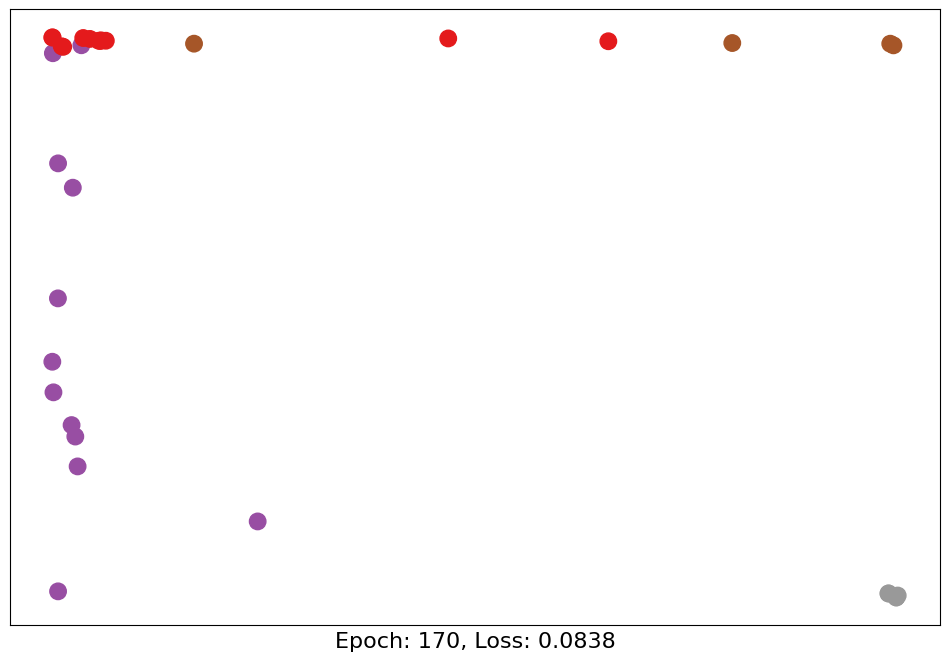

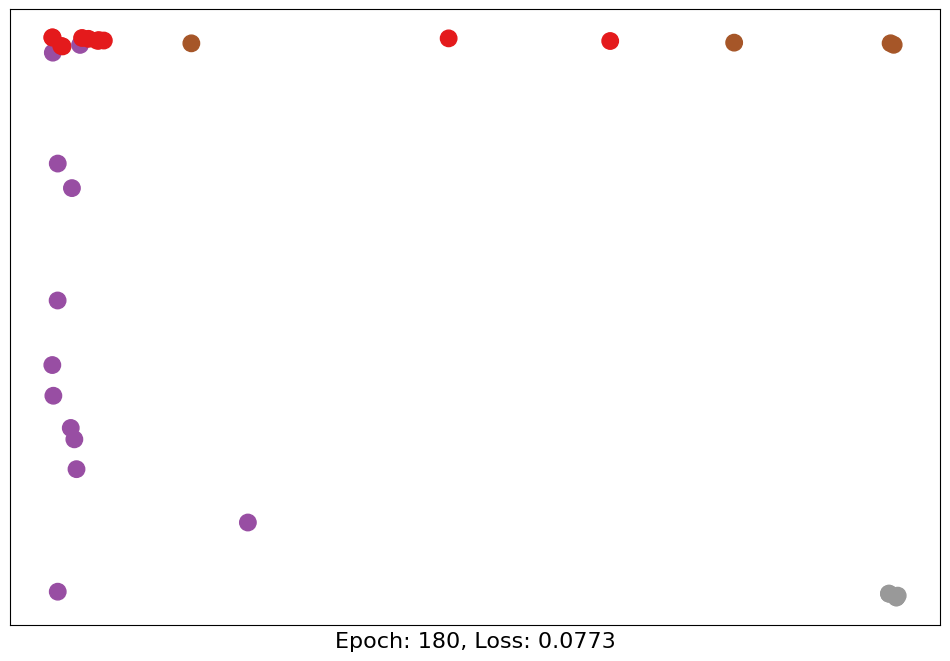

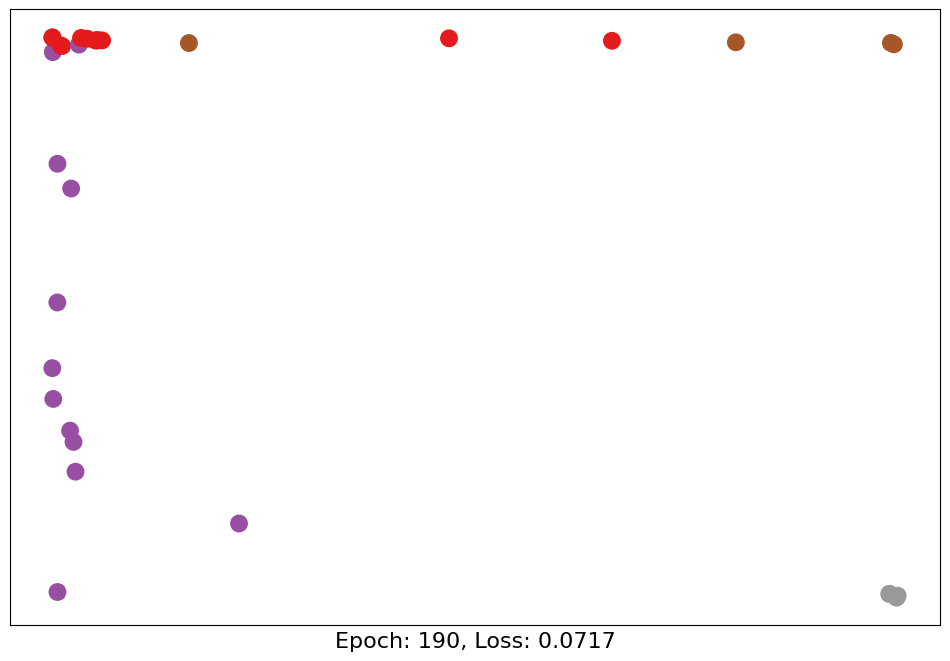

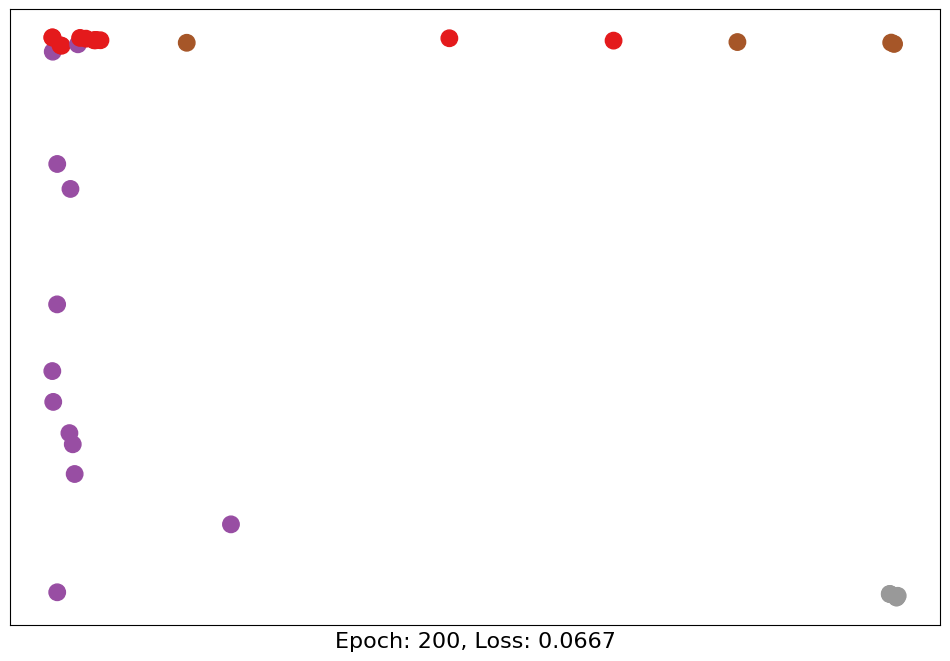

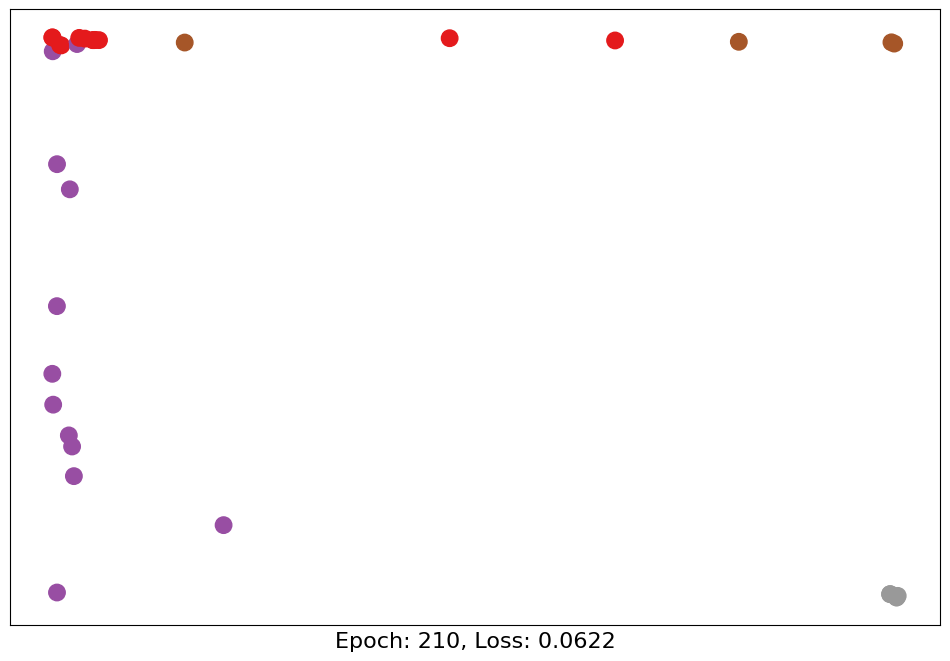

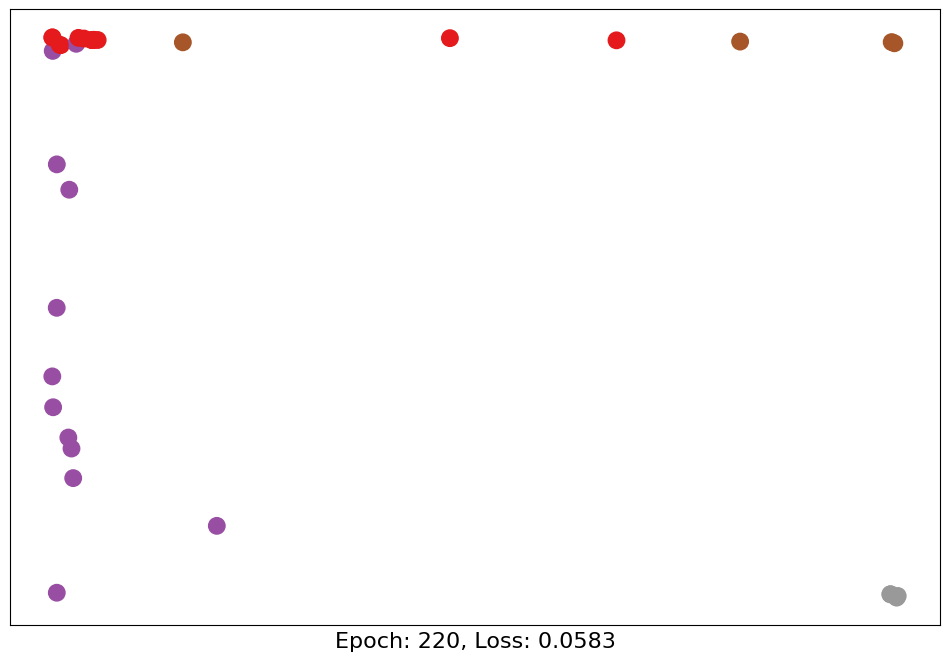

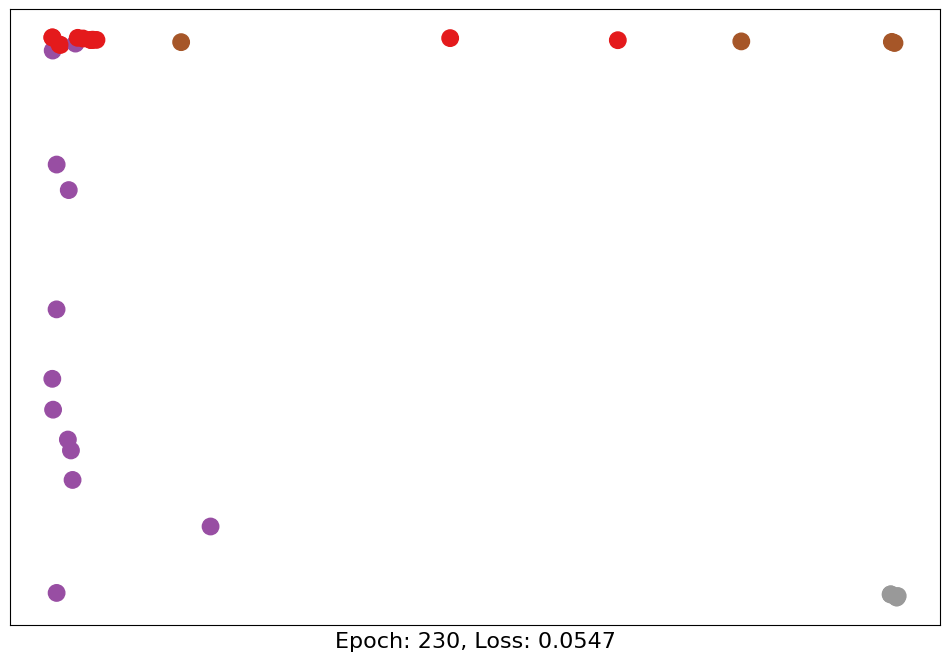

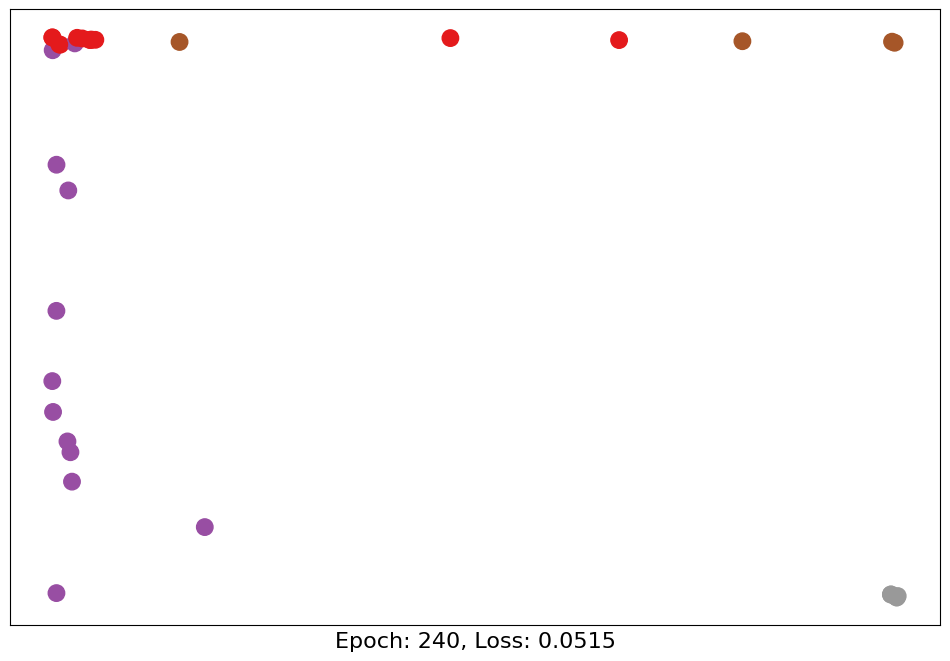

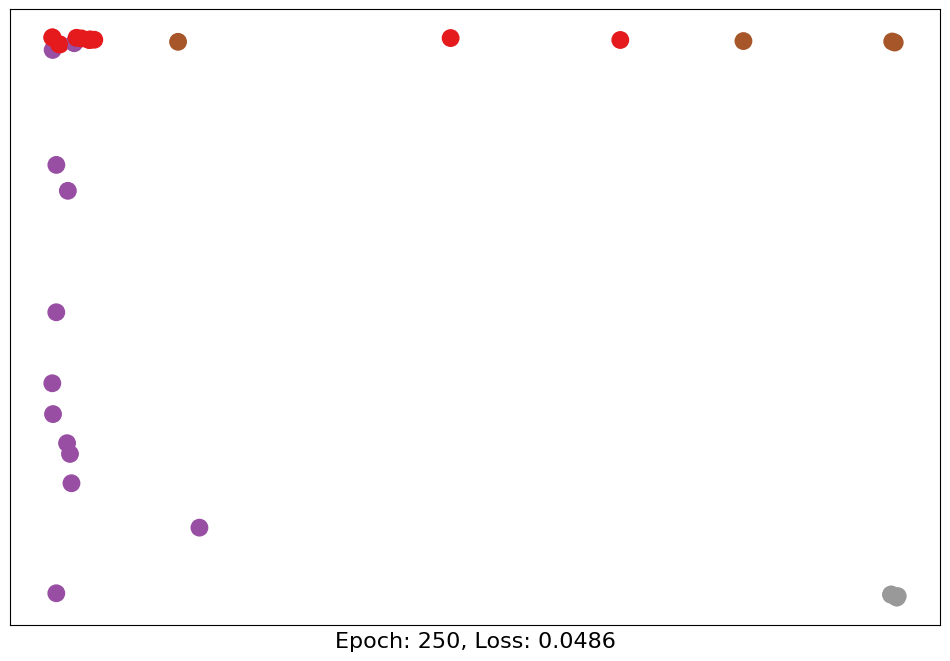

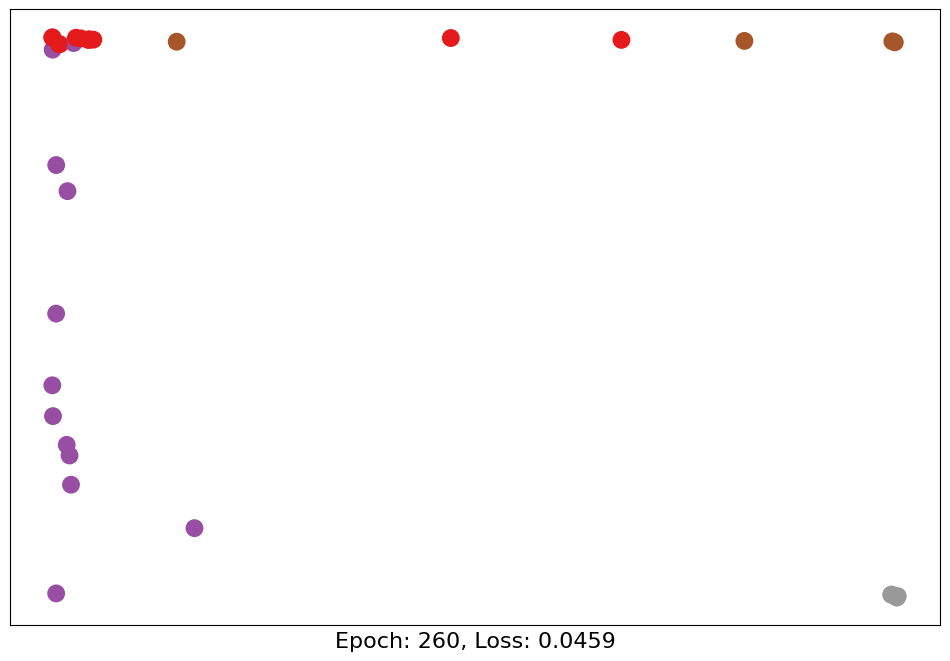

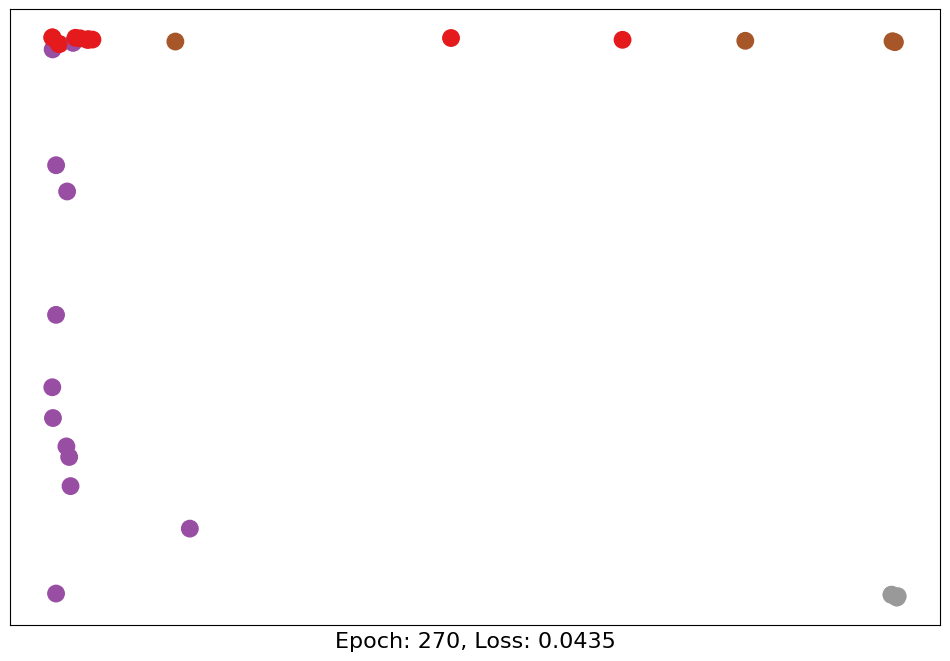

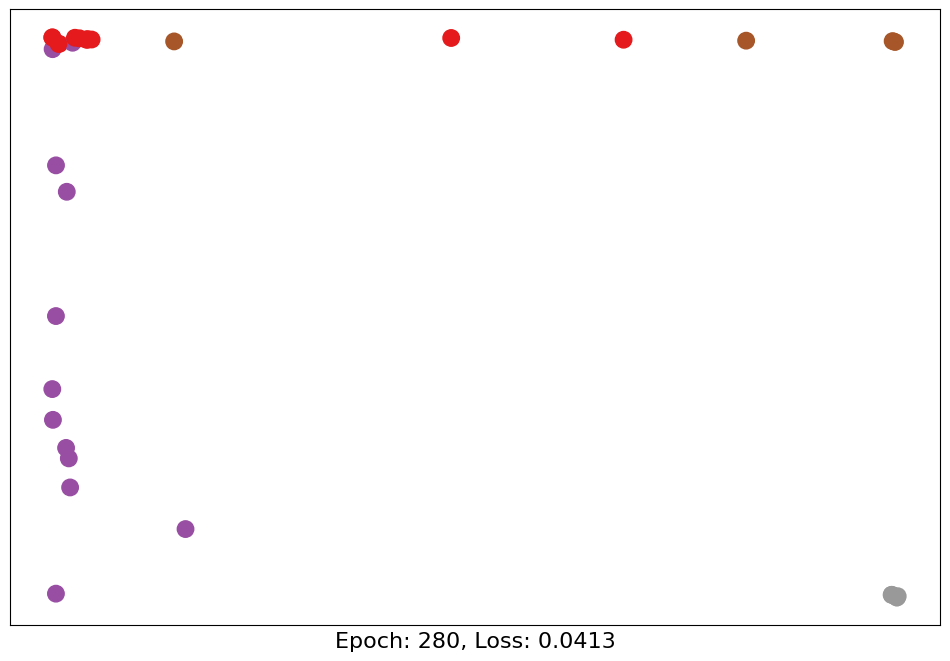

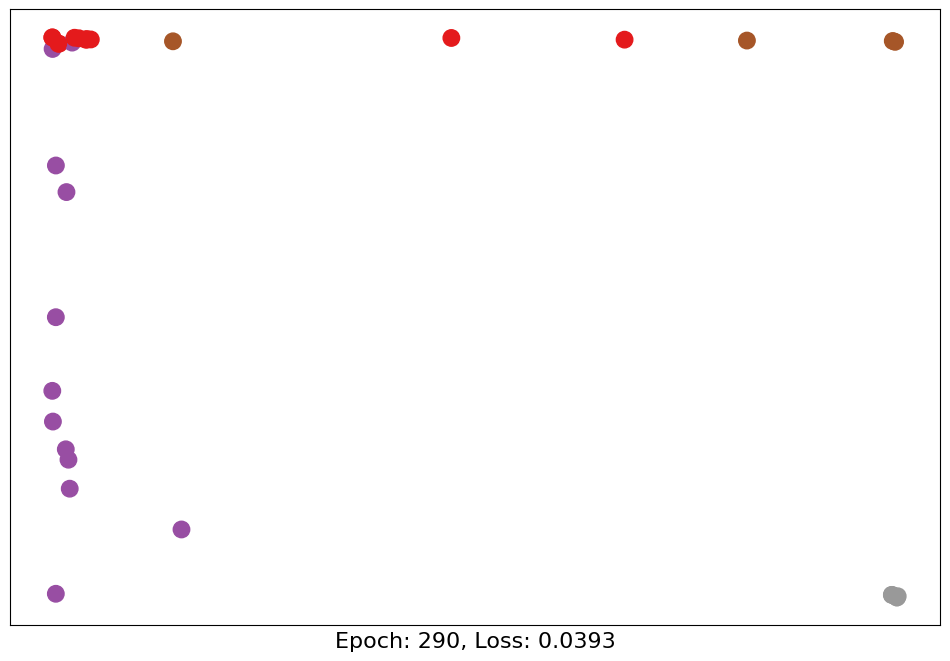

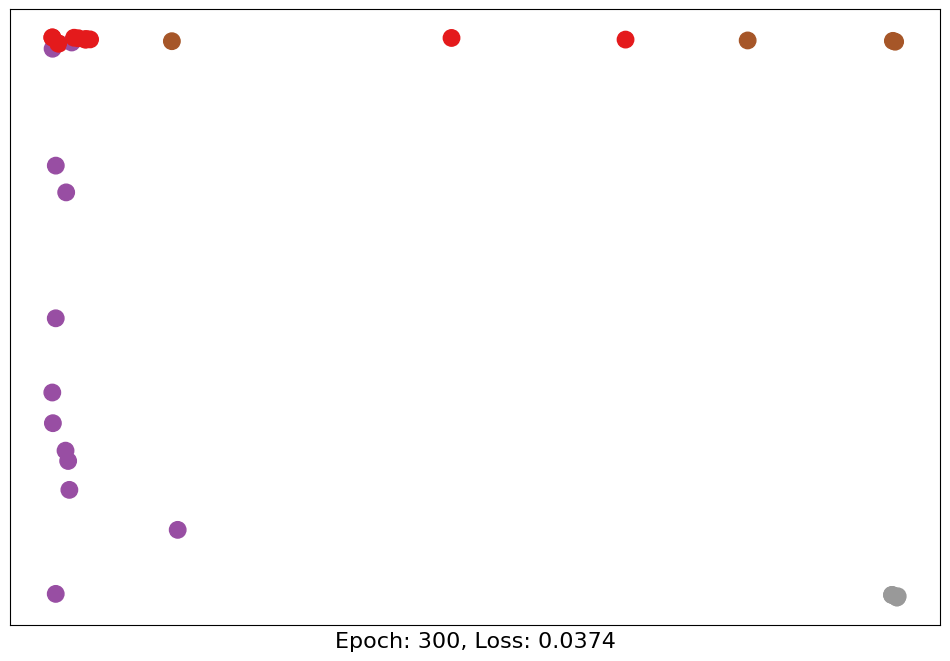

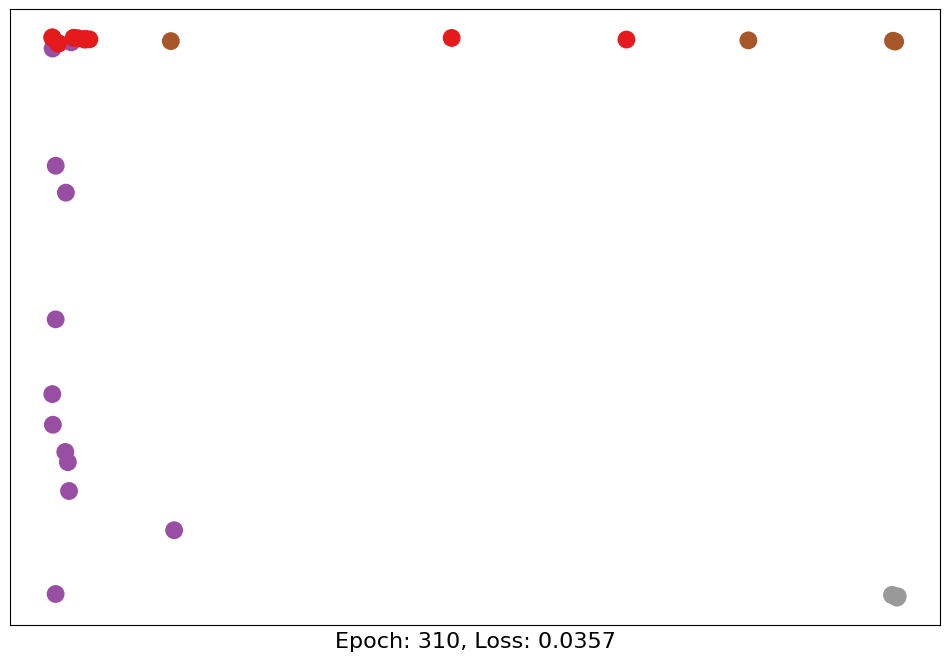

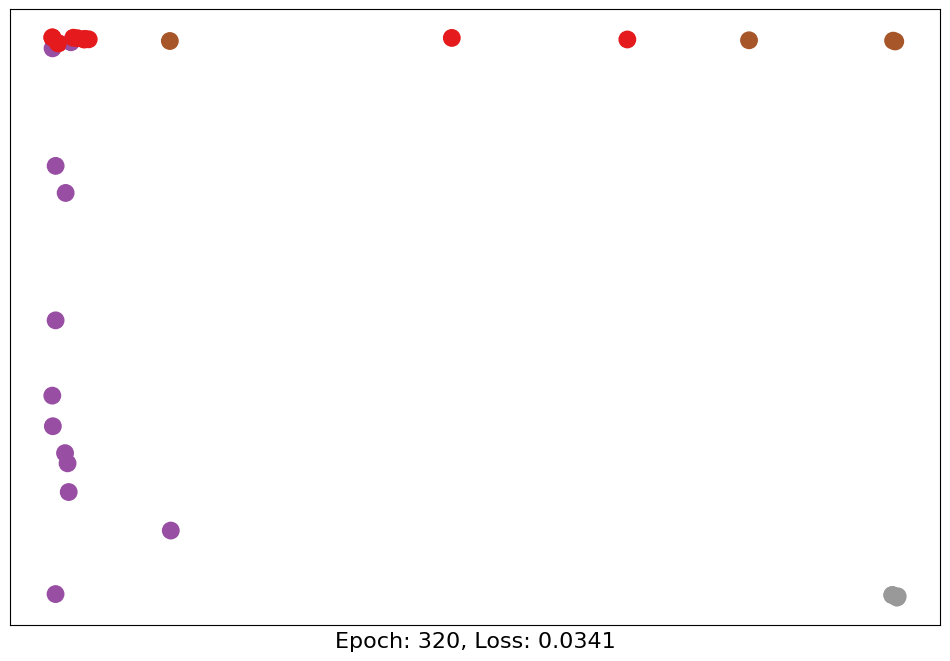

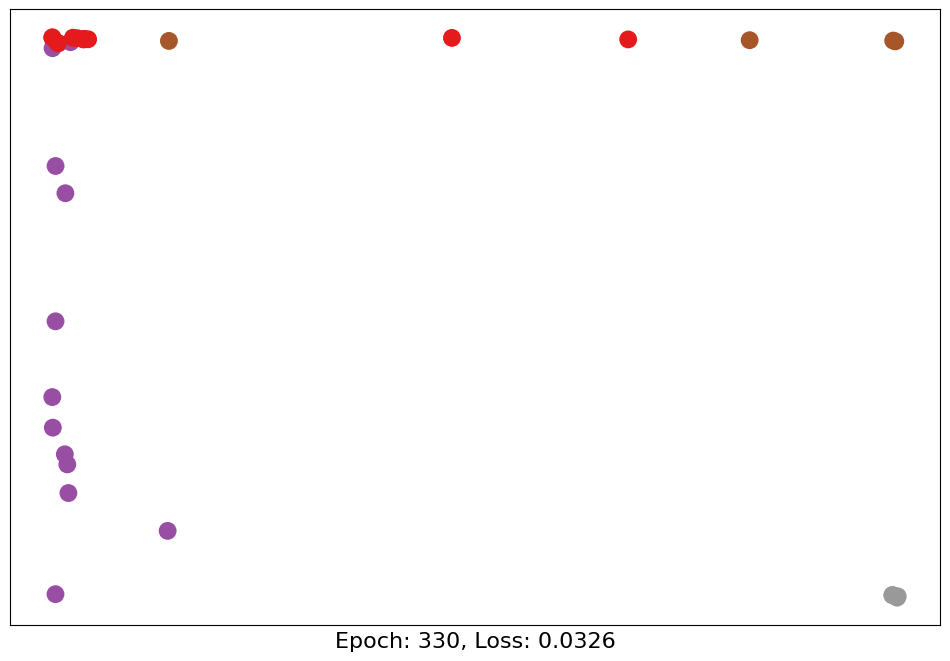

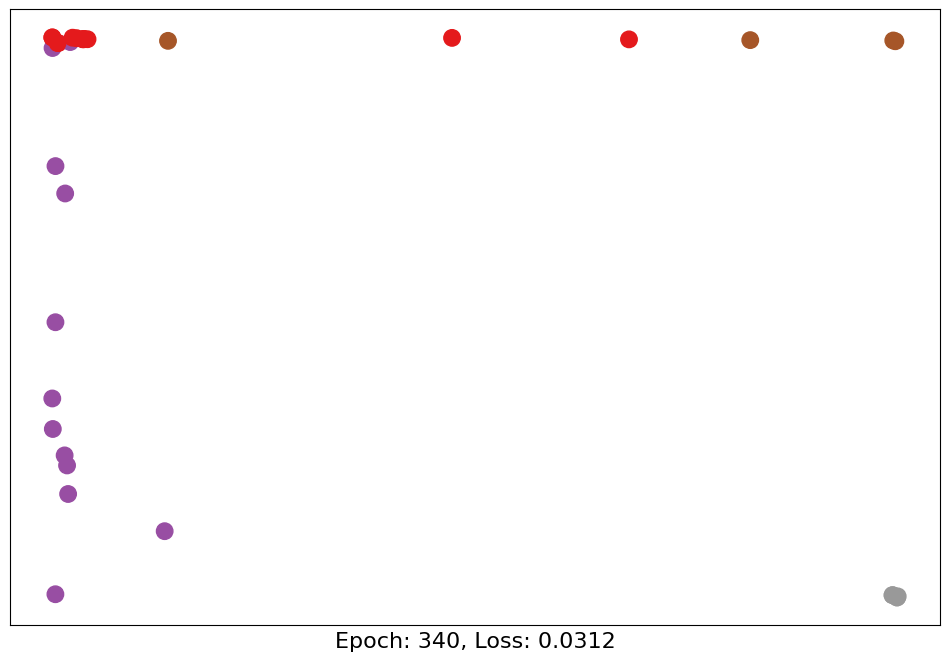

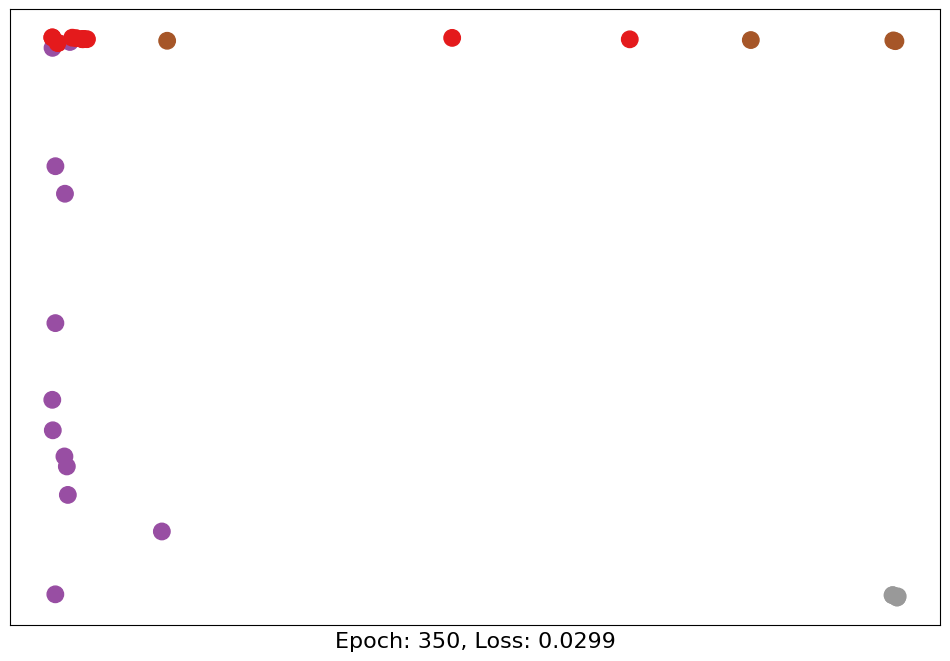

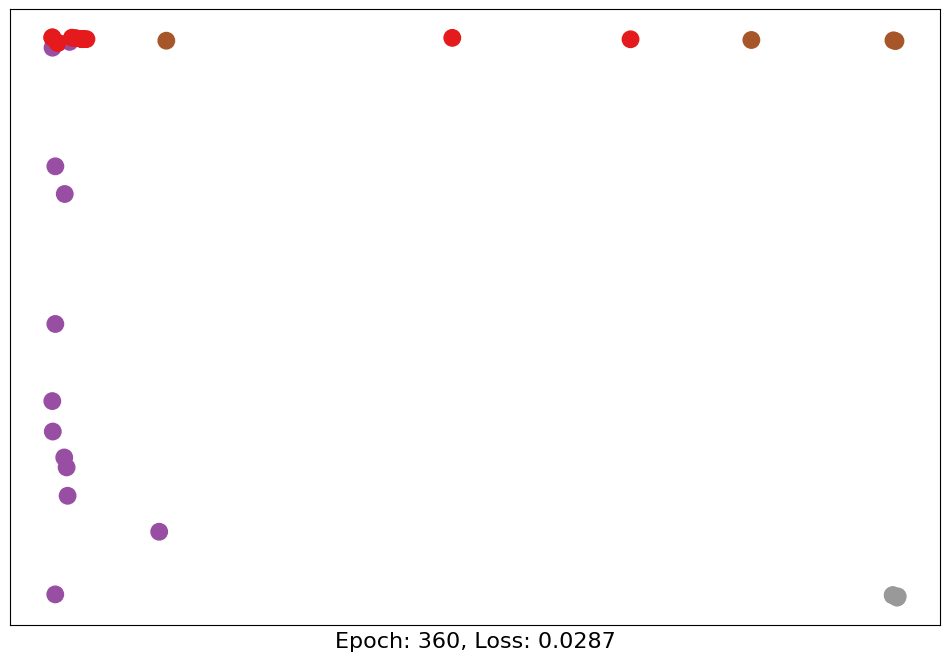

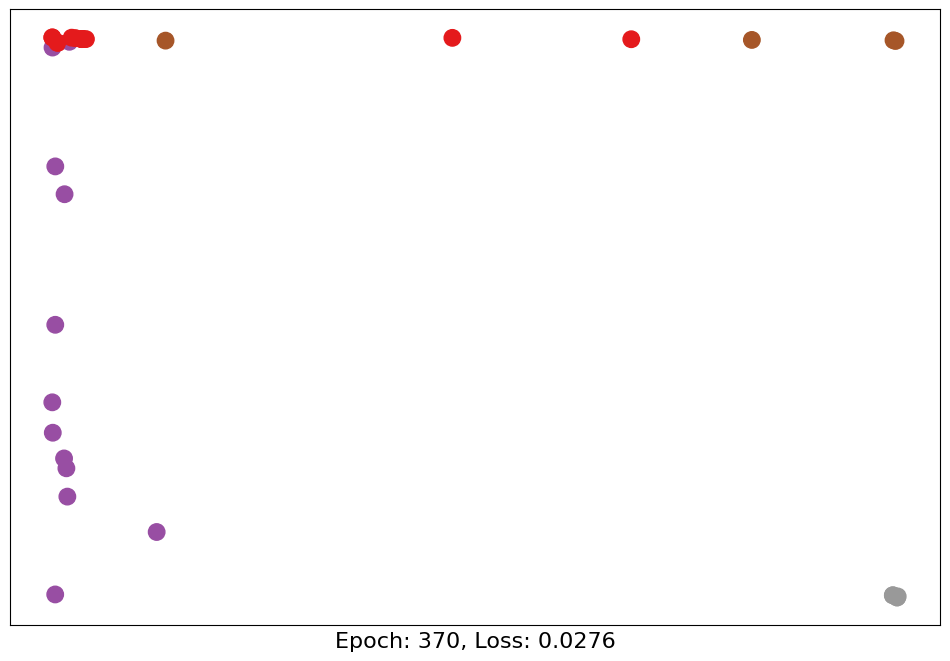

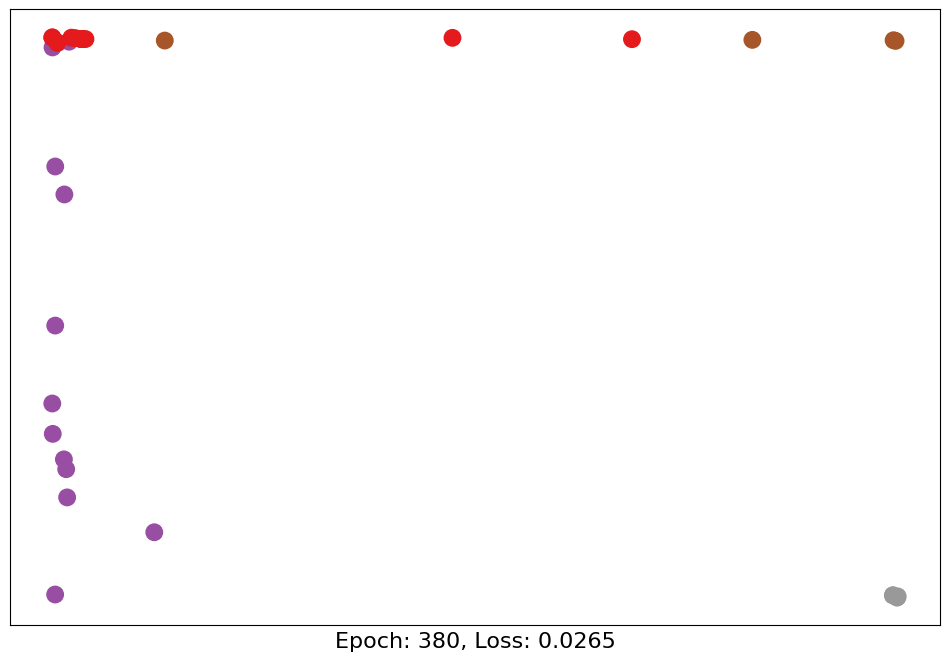

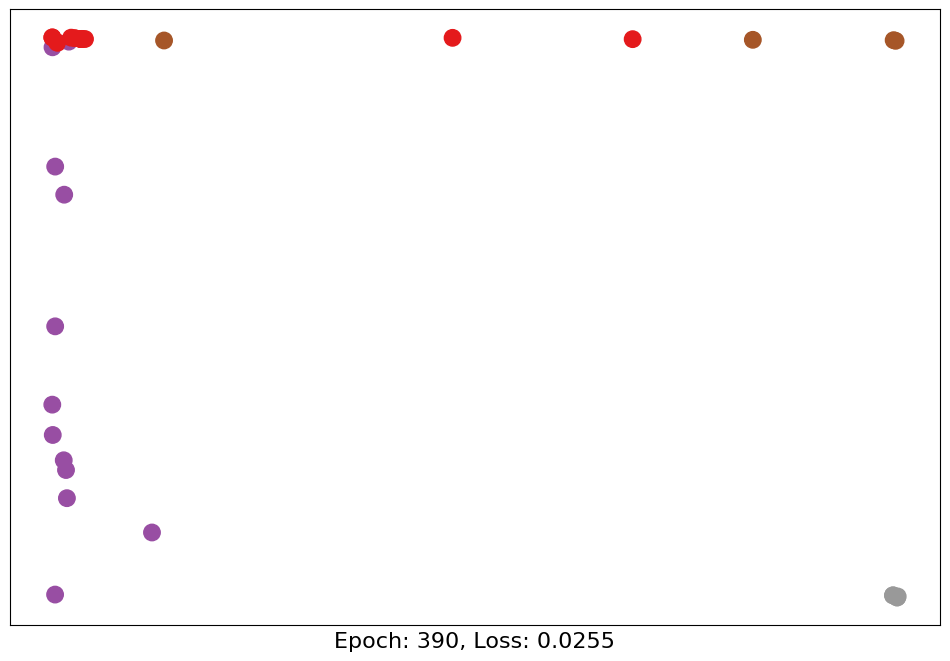

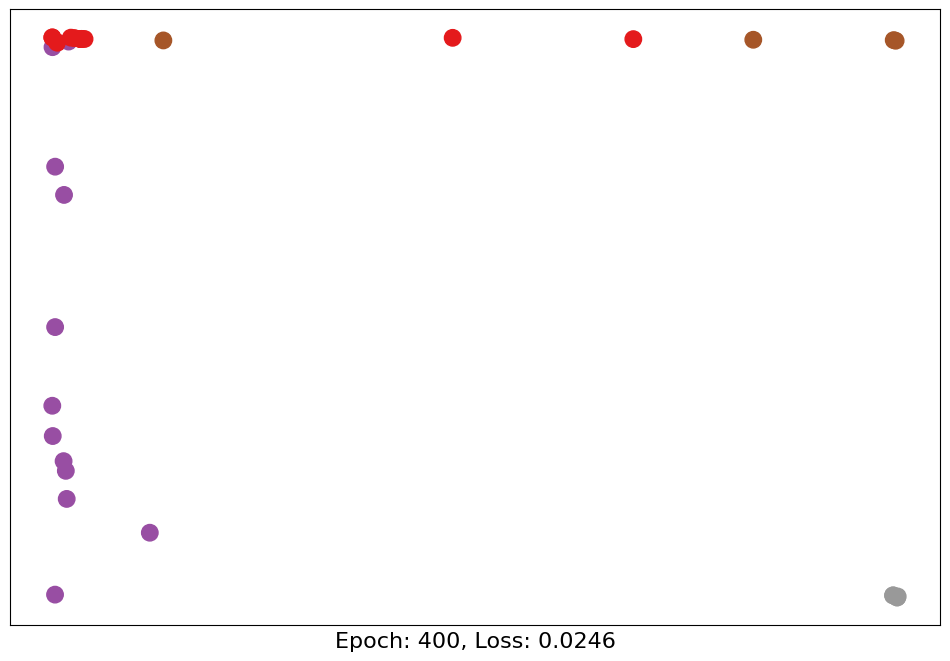

In [95]:
model = GCN(data)
criterion = torch.nn.CrossEntropyLoss()  # Loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

final_h = h
def train(data):
    optimizer.zero_grad()  # Clearing gradients.
    out, h = model(data.x, data.edge_index)  # Forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Calculating loss based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
        ## Added by Me
        final_h = h

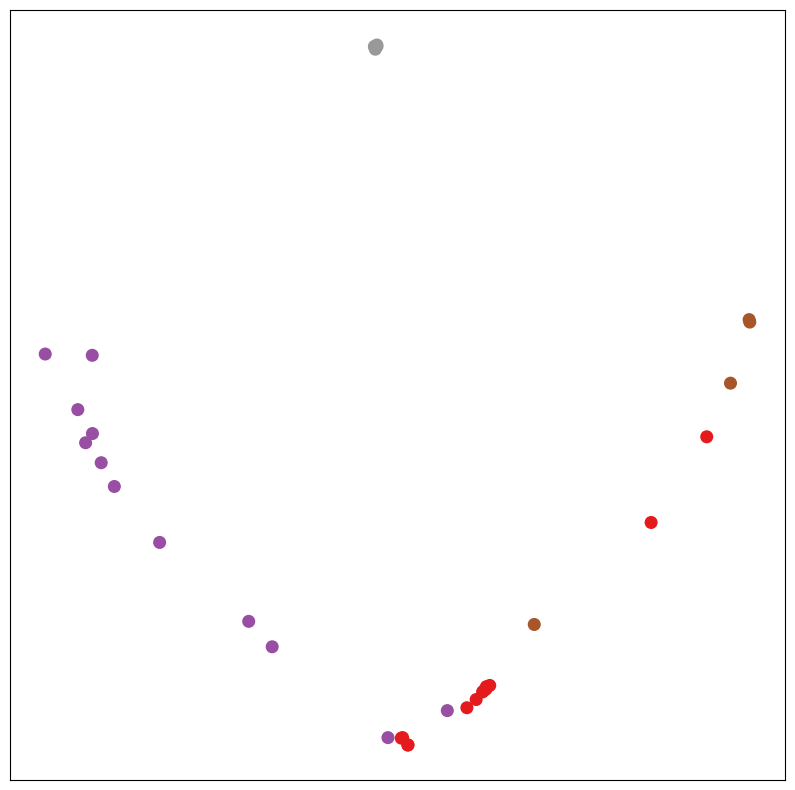

In [96]:
visualize_tsne(h, data.y)

In [97]:
model.eval()
out = model(data.x, data.edge_index)
out

(tensor([[-0.2345,  4.3591, -4.4310,  0.1436],
         [ 1.3456,  2.8111, -2.9429, -1.4126],
         [ 4.3243, -0.1533, -0.0824, -4.3379],
         [ 1.0921,  3.0593, -3.1815, -1.1629],
         [-3.9170,  0.8398,  0.6012,  5.0635],
         [-3.9515,  0.8397,  0.6091,  5.1036],
         [-3.9515,  0.8397,  0.6092,  5.1036],
         [ 1.9870,  2.1490, -2.2986, -2.0382],
         [ 4.3406, -0.2136, -0.0143, -4.3460],
         [ 4.3004, -0.2671,  0.0586, -4.2896],
         [-3.9173,  0.8395,  0.6016,  5.0639],
         [-0.1352,  3.4499, -3.3691,  0.1931],
         [ 0.5090,  3.5199, -3.5986, -0.5685],
         [ 3.3199,  0.8232, -1.0195, -3.3474],
         [ 4.2715, -0.3359,  0.1473, -4.2435],
         [ 4.2691, -0.3384,  0.1509, -4.2402],
         [-3.9464,  0.8293,  0.6204,  5.0996],
         [ 0.7460,  3.2917, -3.3801, -0.8026],
         [ 4.2662, -0.3436,  0.1577, -4.2359],
         [ 3.0462,  1.0192, -1.1912, -3.0647],
         [ 4.2517, -0.3553,  0.1749, -4.2169],
         [ 0.

In [98]:
model.state_dict()

OrderedDict([('conv1.bias', tensor([-0.0398,  0.0074,  0.0530,  0.0303])),
             ('conv1.lin.weight',
              tensor([[ 0.9893, -0.6488, -0.6693, -0.0615,  0.6027,  1.1585,  0.7938, -0.3729,
                       -0.6079, -1.0193,  0.8887, -0.1473,  0.3653, -0.5545, -0.8042, -0.4079,
                        1.0150,  0.2699, -0.9723,  0.0088, -0.6479,  0.1900, -0.3529, -0.5920,
                        0.4493,  0.3951, -0.5013, -0.0678, -1.1910, -1.0785, -1.0772, -0.2185,
                       -0.6120, -0.6529],
                      [-1.0868, -1.3011,  0.2456, -0.7954, -0.4431, -0.2655, -0.8488, -1.2820,
                        0.0860,  0.4040, -0.9798, -0.7531, -1.0100, -0.8316,  0.4007,  0.5778,
                       -0.5675, -1.1067,  0.9949, -1.2402,  0.7423, -1.2624,  0.5717,  0.9572,
                        1.2723,  1.3687,  0.7043,  1.0436,  0.9128,  1.2223,  0.2289,  1.3794,
                        0.5734,  1.0791],
                      [-0.3226,  0.6576,  0.890

In [101]:
print(model.type)

<bound method Module.type of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>


In [100]:
torch.save(model.state_dict(), "karate-club.h5")